In [228]:
symbol = input("Enter the symbol : ")

In [229]:
from nse import *
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [230]:
today = datetime.now()
oneyearago = today - timedelta(days=365*10)

date_format = "%d-%m-%Y"

df = scrape_data(f"{oneyearago.strftime(date_format)}",f"{today.strftime(date_format)}",symbol)
rawdata = df.copy()
df.head()


,Date,Symbol,Series,High Price,Low Price,Open Price,Close Price,Last Price,Prev Close Price,Total Traded Quantity,Total Traded Value,52 Week High Price,52 Week Low Price
0,2013-07-01,INFY,EQ,2473.50,2441.1,2469.0,2451.00,2443.00,2498.85,526135,1.293649e+09,3009.8,2060.55
1,2013-07-02,INFY,EQ,2463.55,2400.0,2448.1,2403.95,2408.20,2451.00,638854,1.548381e+09,3009.8,2060.55
2,2013-07-03,INFY,EQ,2451.90,2392.6,2401.0,2404.50,2406.85,2403.95,668732,1.614146e+09,3009.8,2060.55
3,2013-07-04,INFY,EQ,2475.15,2420.0,2433.0,2468.00,2469.00,2404.50,651348,1.597369e+09,3009.8,2060.55
4,2013-07-05,INFY,EQ,2483.55,2438.7,2467.0,2456.20,2459.00,2468.00,542170,1.336484e+09,3009.8,2060.55


In [231]:
df = df[['Date','High Price', 'Low Price', 'Open Price','Close Price', 'Total Traded Quantity']]
df.columns = ['Date','high', 'low', 'open','close', 'volume']
df.head()

,Date,high,low,open,close,volume
0,2013-07-01,2473.50,2441.1,2469.0,2451.00,526135
1,2013-07-02,2463.55,2400.0,2448.1,2403.95,638854
2,2013-07-03,2451.90,2392.6,2401.0,2404.50,668732
3,2013-07-04,2475.15,2420.0,2433.0,2468.00,651348
4,2013-07-05,2483.55,2438.7,2467.0,2456.20,542170


In [232]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(df['Date'],df['Close'],label="Close", linestyle="-", linewidth=5)

KeyError: 'Close'

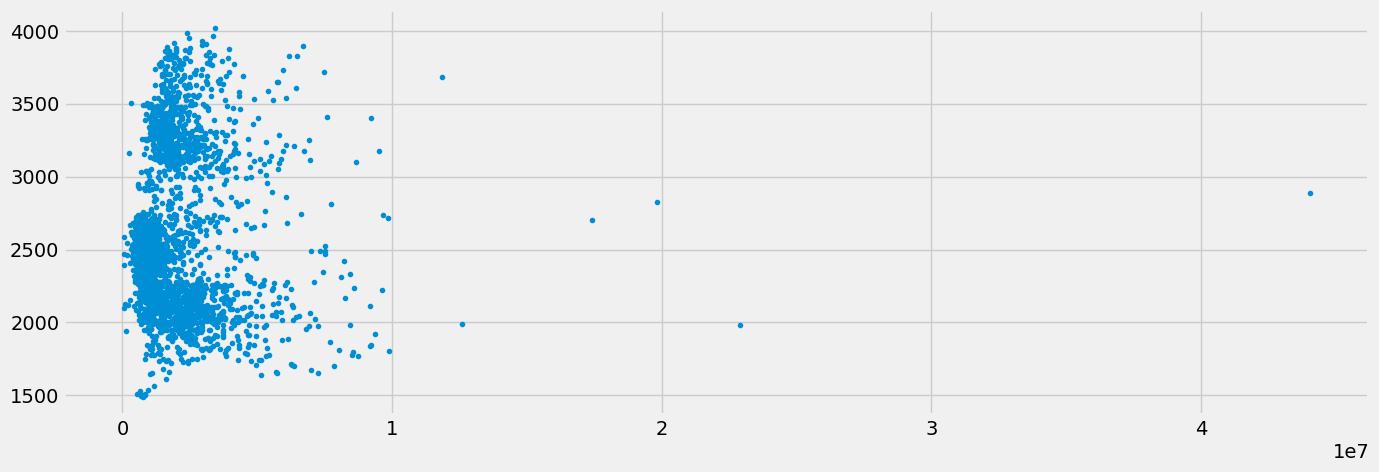

In [ ]:
plt.plot(df['Volume'],df['Close'],linestyle="", marker=".")

In [233]:
def atr_crossover(df, sensitivity=2, atr_period=1):
    xATR = ta.volatility.average_true_range(df["high"], df["low"], df["close"], window=atr_period)

    nLoss = sensitivity * xATR

    src = df['close']

    xATRTrailingStop = pd.Series(np.zeros(len(src)))
    for i in range(1, len(src)):
        if src[i] > xATRTrailingStop[i-1] and src[i-1] > xATRTrailingStop[i-1]:
            xATRTrailingStop[i] = max(xATRTrailingStop[i-1], src[i] - nLoss[i])
        elif src[i] < xATRTrailingStop[i-1] and src[i-1] < xATRTrailingStop[i-1]:
            xATRTrailingStop[i] = min(xATRTrailingStop[i-1], src[i] + nLoss[i])
        elif src[i] > xATRTrailingStop[i-1]:
            xATRTrailingStop[i] = src[i] - nLoss[i]
        else:
            xATRTrailingStop[i] = src[i] + nLoss[i]

    pos = pd.Series(np.zeros(len(src)))
    for i in range(1, len(src)):
        if src[i-1] < xATRTrailingStop[i-1] and src[i] > xATRTrailingStop[i-1]:
            pos[i] = 1
        elif src[i-1] > xATRTrailingStop[i-1] and src[i] < xATRTrailingStop[i-1]:
            pos[i] = -1
        else:
            pos[i] = pos[i-1]

    ema = src.ewm(span=1, adjust=False).mean()
    above = ema > xATRTrailingStop
    below = ema < xATRTrailingStop

    buy = (src > xATRTrailingStop) & above
    sell = (src < xATRTrailingStop) & below

    df["atr_buy"] = buy
    df["atr_sell"] = sell


    # barbuy = src > xATRTrailingStop
    # barsell = src < xATRTrailingStop

    return df

def chandelier_exit(df, atr_period=22, mult=3.0, useClose=True):
    atr = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=atr_period)
    
    if useClose:
        longStop = df['close'].rolling(window=atr_period).max() - atr
        shortStop = df['close'].rolling(window=atr_period).min() + atr
    else:
        longStop = df['high'] - (atr * mult)
        shortStop = df['low'] + (atr * mult)

    buySignal = df['close'] > longStop
    sellSignal = df['close'] < shortStop

    df["ce_buy"] = buySignal
    df["ce_sell"] = sellSignal

    return df

In [234]:
newdf = df.copy()

In [235]:
atr_crossover(newdf, sensitivity=2, atr_period=7)
chandelier_exit(newdf, atr_period=22, mult=3.0)

,Date,high,low,open,close,volume,atr_buy,atr_sell,ce_buy,ce_sell
0,2013-07-01,2473.50,2441.10,2469.00,2451.00,526135,True,False,False,False
1,2013-07-02,2463.55,2400.00,2448.10,2403.95,638854,False,False,False,False
2,2013-07-03,2451.90,2392.60,2401.00,2404.50,668732,False,False,False,False
3,2013-07-04,2475.15,2420.00,2433.00,2468.00,651348,False,False,False,False
4,2013-07-05,2483.55,2438.70,2467.00,2456.20,542170,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2476,2023-06-22,1289.40,1273.50,1289.40,1281.55,6676607,True,False,False,True
2477,2023-06-23,1279.35,1263.35,1276.45,1265.00,7239467,False,True,False,True
2478,2023-06-26,1274.00,1262.25,1270.25,1270.35,3403244,False,True,False,True
2479,2023-06-27,1282.00,1274.20,1280.00,1279.15,3240024,False,True,False,True


(1223.4, 1939.5)

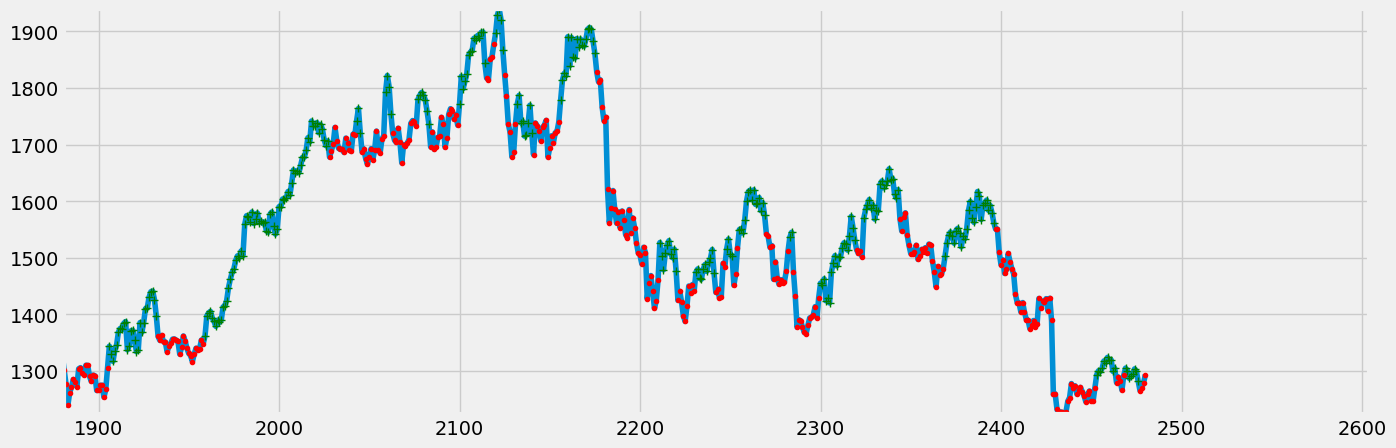

In [240]:
plt.plot(newdf["close"])
plt.plot(newdf["atr_buy"]*newdf["close"], "g +")
plt.plot(newdf["atr_sell"]*newdf["close"], "r .")
plt.xlim(xmin=len(newdf["Date"])-600)
plt.ylim(ymin=min(newdf["close"][-600:]),ymax=max(newdf["close"][-600:]))

(1223.4, 1939.5)

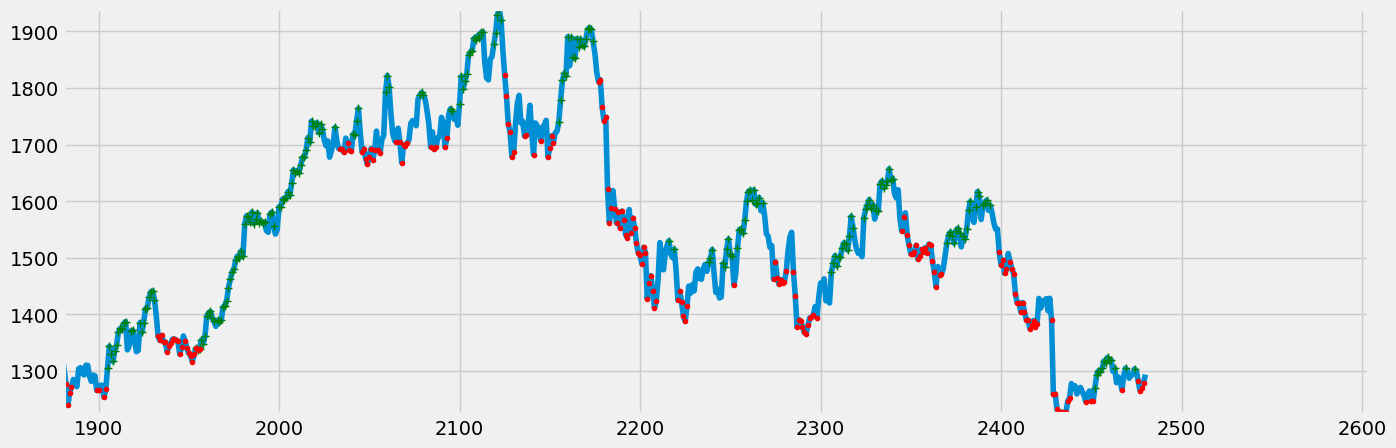

In [242]:
plt.plot(newdf["close"])
plt.plot(newdf["ce_buy"]*newdf["close"], "g +")
plt.plot(newdf["ce_sell"]*newdf["close"], "r .")
plt.xlim(xmin=len(newdf["Date"])-600)
plt.ylim(ymin=min(newdf["close"][-600:]),ymax=max(newdf["close"][-600:]))

In [243]:
indicator = []

for row in newdf[["atr_buy","atr_sell","ce_buy","ce_sell"]].iterrows():
    atr_buy,atr_sell,ce_buy,ce_sell = row[1]
    if atr_buy | ce_buy:
        indicator.append(1)
    elif atr_sell | ce_sell:
        indicator.append(-1)
    else:
        indicator.append(0)

newdf["combineindicator"] = indicator

currbuy = 0
indicator = []
for row in newdf["combineindicator"]:
    if row == currbuy:
        indicator.append(0)
    elif row == 1:
        indicator.append(1)
    elif row == -1:
        indicator.append(-1)
    else:
        indicator.append(0)

    currbuy = row
        
newdf["indicator"] = indicator

(1223.4, 1939.5)

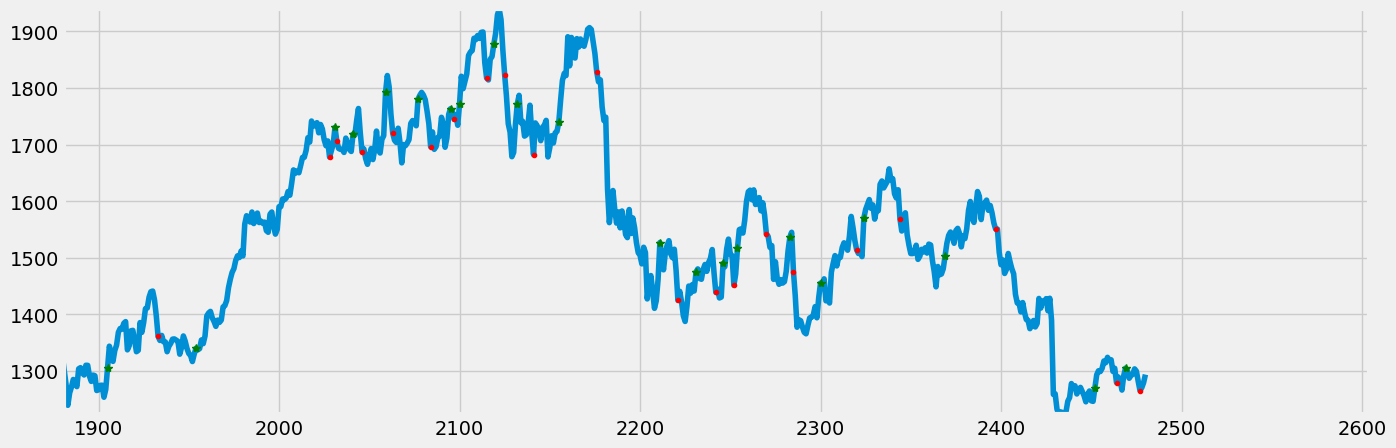

In [246]:
plt.plot(newdf["close"])
plt.plot(newdf["indicator"]*newdf["close"], "g *")
plt.plot(-1*newdf["indicator"]*newdf["close"], "r .")
plt.xlim(xmin=len(newdf["Date"])-600)
plt.ylim(ymin=min(newdf["close"][-600:]),ymax=max(newdf["close"][-600:]))